In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Path to your folder containing 2-sec audio clips
AUDIO_DIR = "2sec_files/"
SAMPLING_RATE = 44100  # Standard sampling rate for audio
DURATION = 2  # 2 seconds
EXPECTED_SHAPE = SAMPLING_RATE * DURATION  # 88200 data points per clip

def load_audio_files(directory):
    audio_data = []
    filenames = os.listdir(directory)

    for file in filenames:
        file_path = os.path.join(directory, file)
        audio, sr = librosa.load(file_path, sr=SAMPLING_RATE)  # Resampling
        if len(audio) < EXPECTED_SHAPE:
            # Zero-pad if shorter
            audio = np.pad(audio, (0, EXPECTED_SHAPE - len(audio)))
        elif len(audio) > EXPECTED_SHAPE:
            # Trim if longer
            audio = audio[:EXPECTED_SHAPE]

        audio_data.append(audio)
    
    return np.array(audio_data)

# Load audio files
clean_audio = load_audio_files(AUDIO_DIR)

# Normalize between -1 and 1
clean_audio = clean_audio / np.max(np.abs(clean_audio))

print("Loaded audio shape:", clean_audio.shape)  # (12, 88200)


Loaded audio shape: (12, 88200)


/var/folders/p0/n2jhl7cx75716fmvf6bswcg00000gn/T/ipykernel_43177/1195668642.py:19: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=SAMPLING_RATE)  # Resampling


In [4]:
def add_gaussian_noise(audio, noise_factor=0.02):
    noise = np.random.normal(0, noise_factor, audio.shape)
    return np.clip(audio + noise, -1.0, 1.0)

def add_white_noise(audio, noise_factor=0.05):
    noise = np.random.uniform(-noise_factor, noise_factor, audio.shape)
    return np.clip(audio + noise, -1.0, 1.0)

def add_background_noise(audio, noise_audio):
    noise_audio = noise_audio[:len(audio)]
    noise_audio = noise_audio * 0.3  # Adjust noise intensity
    return np.clip(audio + noise_audio, -1.0, 1.0)

# Apply noise
noisy_gaussian = np.array([add_gaussian_noise(a) for a in clean_audio])
noisy_white = np.array([add_white_noise(a) for a in clean_audio])

# Use an existing audio file as background noise
background_noise, _ = librosa.load("background_noise.m4a", sr=SAMPLING_RATE)
noisy_background = np.array([add_background_noise(a, background_noise) for a in clean_audio])

# Stack all versions together
noisy_audio = np.vstack([noisy_gaussian, noisy_white, noisy_background])

print("Noisy dataset shape:", noisy_audio.shape)  # (36, 88200)


Noisy dataset shape: (36, 88200)


/var/folders/p0/n2jhl7cx75716fmvf6bswcg00000gn/T/ipykernel_43177/2118870409.py:19: UserWarning: PySoundFile failed. Trying audioread instead.
  background_noise, _ = librosa.load("background_noise.m4a", sr=SAMPLING_RATE)


In [5]:
from sklearn.model_selection import train_test_split

# Repeat clean audio three times to match noisy audio (since we generated 3 variations per file)
clean_audio_expanded = np.tile(clean_audio, (3, 1))

# Reshape for Conv1D (Batch, Time Steps, Features)
noisy_audio = noisy_audio.reshape(-1, EXPECTED_SHAPE, 1)
clean_audio_expanded = clean_audio_expanded.reshape(-1, EXPECTED_SHAPE, 1)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(noisy_audio, clean_audio_expanded, test_size=0.2, random_state=42)

print("Training shape:", X_train.shape)  # (28, 88200, 1)
print("Testing shape:", X_test.shape)    # (8, 88200, 1)


Training shape: (28, 88200, 1)
Testing shape: (8, 88200, 1)


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Input

# Define autoencoder architecture
input_audio = Input(shape=(EXPECTED_SHAPE, 1))

# Encoder
x = Conv1D(16, kernel_size=9, activation="relu", padding="same")(input_audio)
x = MaxPooling1D(pool_size=2, padding="same")(x)
x = Conv1D(8, kernel_size=5, activation="relu", padding="same")(x)
x = MaxPooling1D(pool_size=2, padding="same")(x)

# Decoder
x = Conv1D(8, kernel_size=5, activation="relu", padding="same")(x)
x = UpSampling1D(size=2)(x)
x = Conv1D(16, kernel_size=9, activation="relu", padding="same")(x)
x = UpSampling1D(size=2)(x)

output_audio = Conv1D(1, kernel_size=9, activation="tanh", padding="same")(x)

autoencoder = keras.Model(input_audio, output_audio)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 88200, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 88200, 16)      │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 44100, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 44100, 8)       │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 22050, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 22050, 8)       │           328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 44100, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 44100, 16)      │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 88200, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 88200, 1)       │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,449 (9.57 KB)

 Trainable params: 2,449 (9.57 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train model
history = autoencoder.fit(X_train, Y_train, epochs=50, batch_size=4, validation_data=(X_test, Y_test))

# Save model
autoencoder.save("denoising_autoencoder.h5")


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - loss: 0.0104 - val_loss: 0.0064
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 0.0014 - val_loss: 8.5981e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - loss: 8.3321e-04 - val_loss: 6.3866e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - loss: 5.6760e-04 - val_loss: 4.8524e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - loss: 5.6745e-04 - val_loss: 4.2278e-04
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - loss: 4.7365e-04 - val_loss: 4.6965e-04
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - loss: 4.2179e-04 - val_loss: 5.0233e-04
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - loss: 4.5097e-04 - val_loss: 4.3934e-04
Epoch 12/50
7/7 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


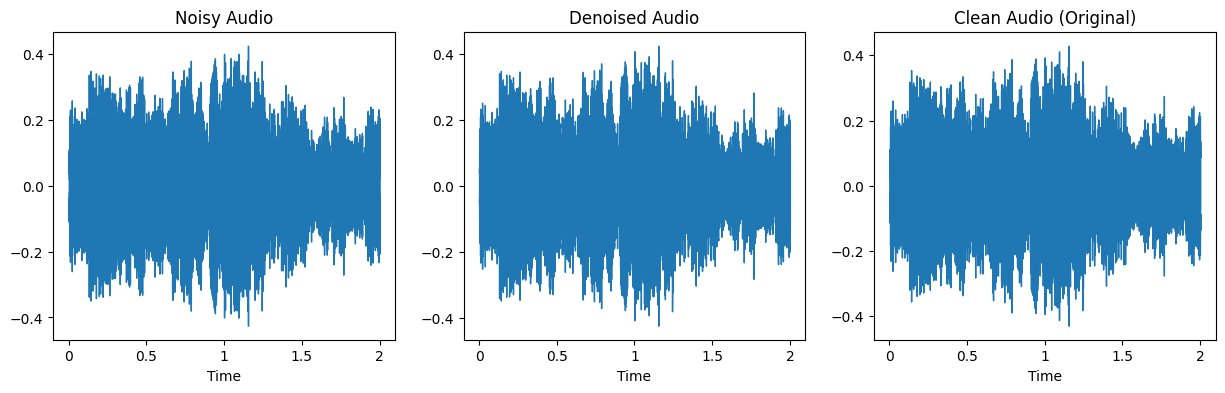

In [8]:
import librosa.display

# Pick a test sample
test_sample = X_test[0]
clean_sample = Y_test[0]

# Get denoised output
denoised_sample = autoencoder.predict(test_sample.reshape(1, -1, 1)).flatten()

# Plot waveforms
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Noisy Audio")
librosa.display.waveshow(test_sample.flatten(), sr=SAMPLING_RATE)

plt.subplot(1, 3, 2)
plt.title("Denoised Audio")
librosa.display.waveshow(denoised_sample, sr=SAMPLING_RATE)

plt.subplot(1, 3, 3)
plt.title("Clean Audio (Original)")
librosa.display.waveshow(clean_sample.flatten(), sr=SAMPLING_RATE)

plt.show()


Available Files:
1. Sample 1
2. Sample 2
3. Sample 3
4. Sample 4
5. Sample 5
6. Sample 6
7. Sample 7
8. Sample 8
9. Sample 9
10. Sample 10
11. Sample 11
12. Sample 12

Displaying results for: Sample 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


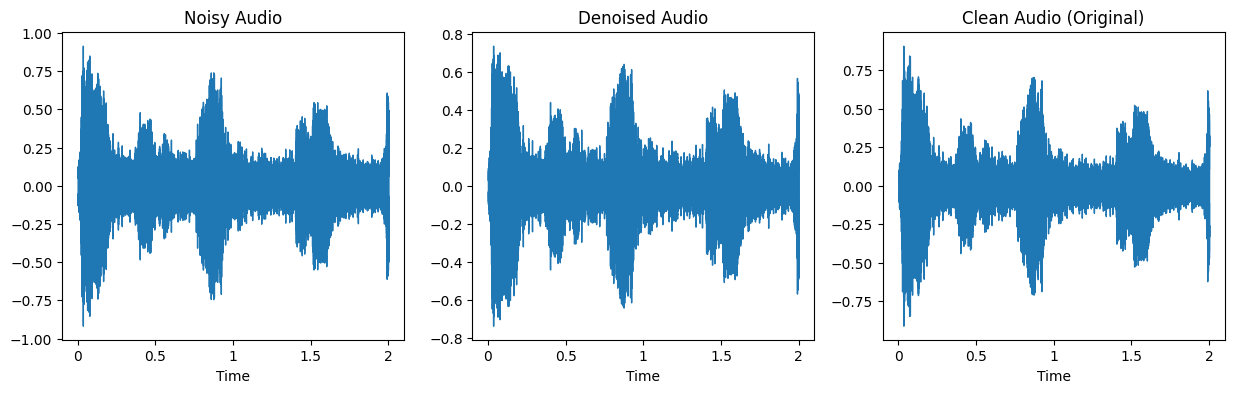

🔹 Noisy Audio


🔹 Denoised Audio


🔹 Clean Audio (Original)


In [11]:
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt

# List of available files (Modify this based on your dataset)
file_list = [f"Sample {i+1}" for i in range(12)]

# Display available files
print("Available Files:")
for i, file in enumerate(file_list):
    print(f"{i+1}. {file}")

# Ask user to select a file
selected_index = int(input("\nEnter the file number (1-12) you want to visualize & play: ")) - 1

# Ensure valid selection
if selected_index < 0 or selected_index >= len(file_list):
    print("Invalid selection! Please restart and enter a number between 1 and 12.")
else:
    print(f"\nDisplaying results for: {file_list[selected_index]}")

    # Extract the selected file's noisy and clean versions
    test_sample = X_test[selected_index]
    clean_sample = Y_test[selected_index]

    # Get denoised output
    denoised_sample = autoencoder.predict(test_sample.reshape(1, -1, 1)).flatten()

    # Plot waveforms
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    plt.title("Noisy Audio")
    librosa.display.waveshow(test_sample.flatten(), sr=SAMPLING_RATE)

    plt.subplot(1, 3, 2)
    plt.title("Denoised Audio")
    librosa.display.waveshow(denoised_sample, sr=SAMPLING_RATE)

    plt.subplot(1, 3, 3)
    plt.title("Clean Audio (Original)")
    librosa.display.waveshow(clean_sample.flatten(), sr=SAMPLING_RATE)

    plt.show()

    # Play the selected audio files
    print("🔹 Noisy Audio")
    ipd.display(ipd.Audio(test_sample.flatten(), rate=SAMPLING_RATE))

    print("🔹 Denoised Audio")
    ipd.display(ipd.Audio(denoised_sample, rate=SAMPLING_RATE))

    print("🔹 Clean Audio (Original)")
    ipd.display(ipd.Audio(clean_sample.flatten(), rate=SAMPLING_RATE))


In [13]:
pip install keras_tuner

Note: you may need to restart the kernel to use updated packages.


In [14]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Input

def build_model(hp):
    input_audio = Input(shape=(EXPECTED_SHAPE, 1))

    # Hyperparameter tuning for filter size & depth
    x = Conv1D(
        filters=hp.Choice('filters_1', values=[8, 16, 32]),
        kernel_size=hp.Choice('kernel_1', values=[5, 9, 15]),
        activation="relu",
        padding="same"
    )(input_audio)

    x = MaxPooling1D(pool_size=2, padding="same")(x)

    x = Conv1D(
        filters=hp.Choice('filters_2', values=[8, 16, 32]),
        kernel_size=hp.Choice('kernel_2', values=[3, 5, 7]),
        activation="relu",
        padding="same"
    )(x)

    x = MaxPooling1D(pool_size=2, padding="same")(x)

    # Decoder
    x = Conv1D(
        filters=hp.Choice('filters_3', values=[8, 16, 32]),
        kernel_size=hp.Choice('kernel_3', values=[3, 5, 7]),
        activation="relu",
        padding="same"
    )(x)

    x = UpSampling1D(size=2)(x)

    x = Conv1D(
        filters=hp.Choice('filters_4', values=[8, 16, 32]),
        kernel_size=hp.Choice('kernel_4', values=[5, 9, 15]),
        activation="relu",
        padding="same"
    )(x)

    x = UpSampling1D(size=2)(x)

    output_audio = Conv1D(1, kernel_size=9, activation="tanh", padding="same")(x)

    model = keras.Model(input_audio, output_audio)

    # Hyperparameter tuning for learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="mse")

    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=2,
    directory="hyperparam_tuning",
    project_name="denoising_autoencoder"
)

tuner.search(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test), batch_size=4)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), batch_size=4)


Trial 10 Complete [00h 02m 28s]
val_loss: 0.0005614669935312122

Best val_loss So Far: 0.00019826636707875878
Total elapsed time: 00h 20m 41s
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 855ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 612ms/step - loss: 0.0060 - val_loss: 0.0020
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 484ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - loss: 0.0011 - val_loss: 8.9593e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 569ms/step - loss: 8.5658e-04 - val_loss: 6.5703e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - loss: 6.0205e-04 - val_loss: 5.4270e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - loss: 5.4429e-04 - val_loss: 4.3765e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - loss: 4.3371e-04 - val_loss: 4.0747e-04
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - loss: 3.7993e-04 - val_loss: 3.6246e-04
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step - loss:

In [15]:
# Get the best hyperparameters from tuning
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model using the selected hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, Y_train, 
                         epochs=50,  # Increase epochs if needed
                         validation_data=(X_test, Y_test),
                         batch_size=4)

# Save the trained model
best_model.save("best_autoencoder_model.h5")


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 632ms/step - loss: 0.0119 - val_loss: 0.0073
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 487ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 497ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 535ms/step - loss: 0.0012 - val_loss: 9.1274e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 519ms/step - loss: 8.8356e-04 - val_loss: 5.9124e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - loss: 5.8014e-04 - val_loss: 5.2129e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - loss: 6.4499e-04 - val_loss: 4.7636e-04
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step - loss: 5.2919e-04 - val_loss: 3.9347e-04
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - loss: 3.5033e-04 - val_loss: 3.5249e-04
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 479ms/step - loss: 3.6854e-04 - val_loss: 3.1791e-04
Epoch 12/50
7/7 ━━━━━━

In [16]:
# Evaluate on test set
test_loss = best_model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step - loss: 1.7397e-04
Test Loss: 0.000174
